In [1]:
import sys
sys.path.append('../')

In [3]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from util import save_history, save_model, plot_metrics, plot_visualizations

In [4]:
base_model_version = "v8.0"
model_version = "v8.2"

In [5]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [7]:
with open('../data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [8]:
df = pd.read_csv(f"../data/processed/photometry_only.csv")

X = df[photo_cols + generic_cols]
y = df[target_col]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
input_shape = X_train_scaled.shape[1]

inputs = keras.Input(shape=(input_shape,))

x = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_16')(inputs)
x = layers.Dropout(0.3)(x)

x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_32')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_64')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_128')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_256')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_32.2')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_16.2')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.load_weights(f'../models/{base_model_version}/spec_photo_model.h5', by_name=True, skip_mismatch=True)

model.get_layer('Dense_32').trainable = False
model.get_layer('Dense_64').trainable = True
model.get_layer('Dense_128').trainable = False
model.get_layer('Dense_256').trainable = False
model.get_layer('Dense_32.2').trainable = True

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', 'mape'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 39)]              0         
                                                                 
 Dense_16 (Dense)            (None, 16)                640       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 Dense_32 (Dense)            (None, 32)                544       
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 Dense_64 (Dense)            (None, 64)                2112      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0   

In [40]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=64, validation_split=0.4, verbose=1, callbacks=[early_stopping])

Epoch 1/200
1676/1676 [==============================] - 21s 12ms/step - loss: 9.3747 - mae: 2.2510 - mse: 8.8466 - mape: 21.2601 - val_loss: 2.1960 - val_mae: 1.2888 - val_mse: 1.7607 - val_mape: 12.0424
Epoch 2/200
1676/1676 [==============================] - 25s 15ms/step - loss: 3.8324 - mae: 1.4733 - mse: 3.4537 - mape: 13.9264 - val_loss: 0.7776 - val_mae: 0.6080 - val_mse: 0.4324 - val_mape: 5.6973
Epoch 3/200
1676/1676 [==============================] - 24s 15ms/step - loss: 2.7987 - mae: 1.2491 - mse: 2.4649 - mape: 11.8209 - val_loss: 0.4925 - val_mae: 0.3512 - val_mse: 0.1693 - val_mape: 3.3194
Epoch 4/200
1676/1676 [==============================] - 24s 14ms/step - loss: 2.2387 - mae: 1.1046 - mse: 1.9273 - mape: 10.4586 - val_loss: 0.4121 - val_mae: 0.2711 - val_mse: 0.1113 - val_mape: 2.5762
Epoch 5/200
1676/1676 [==============================] - 24s 14ms/step - loss: 1.7298 - mae: 0.9531 - mse: 1.4372 - mape: 9.0242 - val_loss: 0.3916 - val_mae: 0.2440 - val_mse: 0.1054

In [41]:
y_pred = model.predict(X_test_scaled)

1396/1396 [==============================] - 2s 1ms/step


In [42]:
Eval.plot_metrics(y_test, y_pred)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.1636
Root Mean Squared Error (RMSE): 0.2724
R² Score: 0.8296


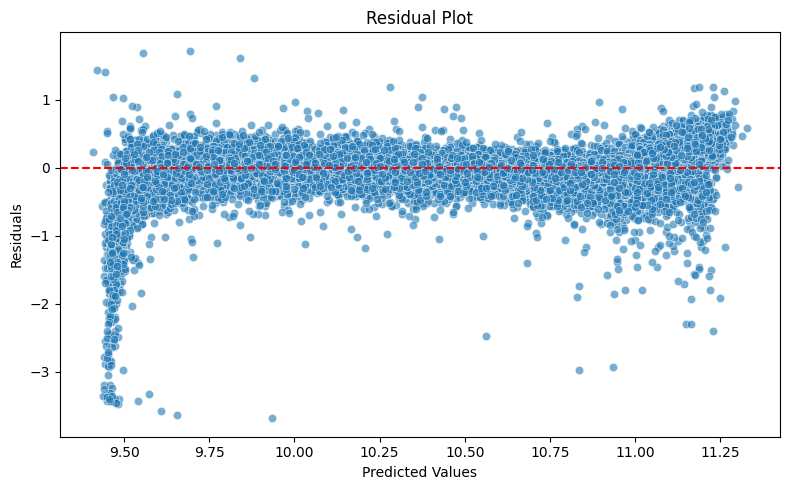

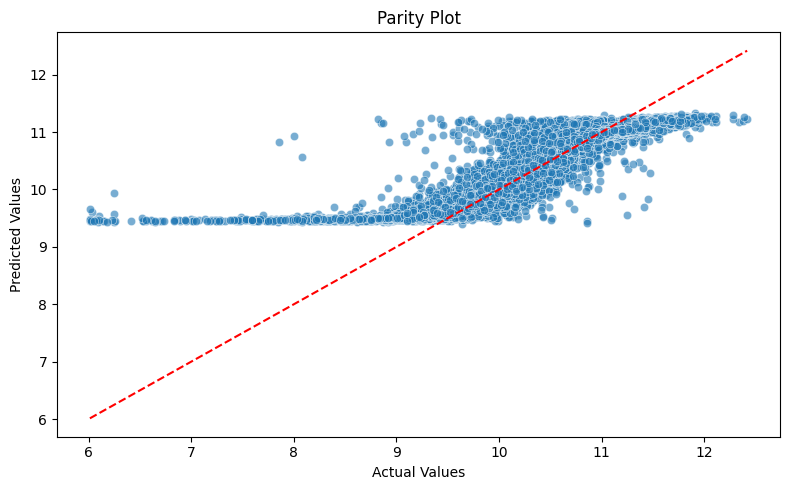

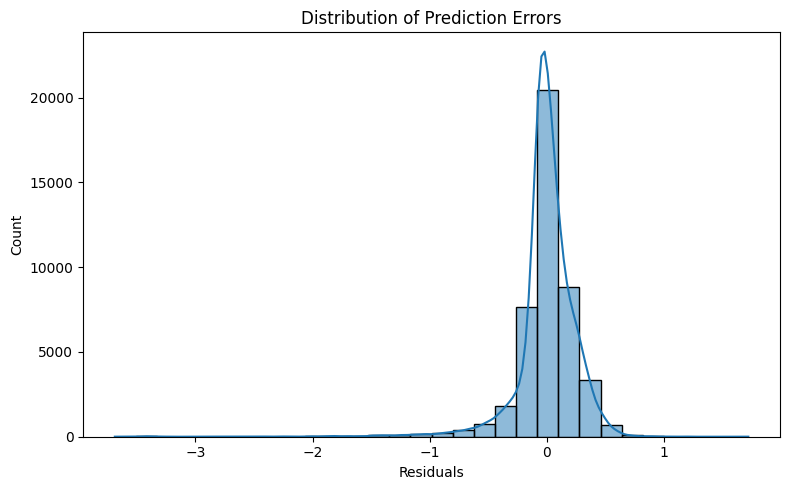

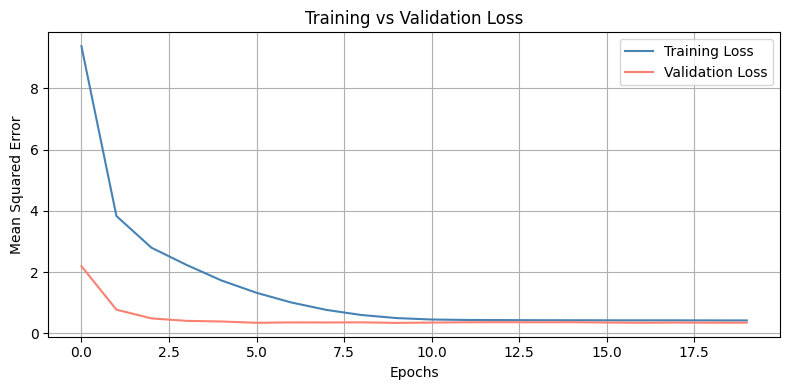

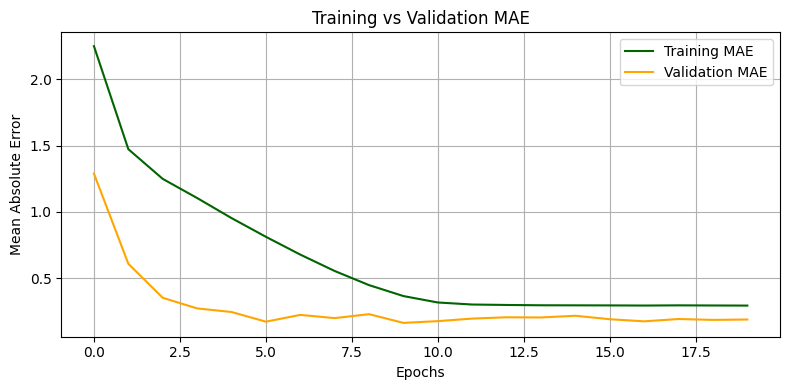

In [43]:
Eval.plot_visualizations(history, y_test, y_pred)